In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# RandomForest (train raw)

In [ ]:
# Cargar datos de entrenamiento
df_train = pd.read_csv("../data/train_reviews.csv")
df_train['text'] = df_train['text'].fillna("")
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['year'] = df_train['date'].dt.year

# Seleccionar características adicionales de review, por ejemplo:
other_features = ['useful', 'funny', 'cool', 'year']
X_other_train = df_train[other_features].values

# Procesar el texto con TF-IDF en el training
tfidf = TfidfVectorizer(max_features=5000)
X_text_train_tfidf = tfidf.fit_transform(df_train['text'])

# Reducir la dimensionalidad del texto
svd = TruncatedSVD(n_components=50, random_state=42)
X_text_train_svd = svd.fit_transform(X_text_train_tfidf)

In [ ]:
X_text_train_svd.shape, X_other_train.shape

In [3]:
# Combinar las características numéricas con el embedding del texto
X_train = np.hstack([X_other_train, X_text_train_svd])
y_train = df_train['stars']

# Dividir el conjunto de entrenamiento en entrenamiento y validación
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Entrenar el modelo RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42, verbose=1, n_jobs=-1)
model.fit(X_train_final, y_train_final)

# Predecir en el conjunto de validación para evaluar
y_pred_val = model.predict(X_val)
print("MAE en validación:", mean_absolute_error(y_val, y_pred_val))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 18.7min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


MAE en validación: 0.720318928216396


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.4s finished


In [5]:
# Ahora, procesar el conjunto de test (sin ajustar de nuevo el vectorizador ni el SVD)
df_test = pd.read_csv('../data/test_reviews.csv')
df_test['text'] = df_test['text'].fillna("")
df_test['date'] = pd.to_datetime(df_test['date'])
df_test['year'] = df_test['date'].dt.year

X_other_test = df_test[other_features].values

# Transformar el texto de test con el vectorizador y el SVD ya ajustados
X_text_test_tfidf = tfidf.transform(df_test['text'])
X_text_test_svd = svd.transform(X_text_test_tfidf)

# Combinar las características
X_test = np.hstack([X_other_test, X_text_test_svd])

# Realizar las predicciones en el conjunto de test
predictions = model.predict(X_test)

# Crear el DataFrame con el formato requerido: review_id, stars
df_output = pd.DataFrame({
    'review_id': df_test['review_id'],
    'stars': predictions.round(0)  
})

# Exportar el CSV con las predicciones
df_output.to_csv('random_forest_review_predictions.csv', index=False)
print("Predicciones exportadas a 'test_review_predictions.csv'")

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    3.0s finished


Predicciones exportadas a 'test_review_predictions.csv'


# RandomForest (train + neg)

In [3]:
df_train = pd.read_csv("../data/train_reviews_merged_final.csv")
df_train['text'] = df_train['text'].fillna("")

df_train.sample(5)

,stars,useful,funny,cool,text,date,stars_neg,review_count_neg,is_open_neg,categories_neg,review_count_user,average_stars_user,compliment_user
578521,5.0,-0.391093,0.300774,-0.251644,The Best Cheesesteaks in Broomall and the soun...,2019,4.0,0.995090,True,Restaurante,-0.198135,2.50,-0.033875
826009,5.0,-0.062341,-0.150312,0.255613,One of my favorite things about Philly. Open e...,2017,4.5,44.964332,True,Restaurante,-0.075113,4.54,-0.030243
907328,4.0,-0.391093,-0.150312,-0.251644,Pizza was good they forgot my garlic butter. B...,2019,4.0,2.191154,True,Restaurante,-0.288352,2.50,-0.035085
856891,5.0,1.252664,-0.150312,-0.251644,Straightforward ethical clinic. I appreciate ...,2018,4.5,-0.232659,True,Otros,0.121723,4.72,-0.019349
300265,3.0,-0.391093,-0.150312,-0.251644,i went here and didnt stay because they dont h...,2017,2.0,-0.145528,True,Restaurante,-0.189934,3.93,-0.035085


Omito date

In [5]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X_numeric = df_train[["useful", "funny", "cool", "stars_neg", "review_count_neg", "categories_neg", "review_count_user", "average_stars_user", "compliment_user"]].copy()
X_numeric["is_open_neg"] = df_train["is_open_neg"].astype(int)

X_numeric

,useful,funny,cool,stars_neg,review_count_neg,categories_neg,review_count_user,average_stars_user,compliment_user,is_open_neg
0,-0.391093,-0.150312,-0.251644,4.5,0.773303,Restaurante,-0.230941,4.08,-0.033875,1
1,0.266410,-0.150312,0.255613,2.5,-0.177212,Otros,-0.050509,2.89,-0.035085,1
2,-0.391093,-0.150312,-0.251644,2.5,-0.296027,Compras,-0.271949,3.75,-0.033875,1
3,-0.391093,-0.150312,-0.251644,4.5,0.226757,Restaurante,0.146327,3.79,-0.032664,0
4,2.896420,1.654029,3.299152,4.0,-0.105924,Restaurante,1.138707,4.20,0.004861,1
...,...,...,...,...,...,...,...,...,...,...
967779,-0.062341,-0.150312,-0.251644,4.5,0.812908,Restaurante,0.105320,4.58,-0.031454,0
967780,-0.391093,-0.150312,-0.251644,4.5,0.900038,Restaurante,1.417558,3.74,-0.030243,1
967781,-0.391093,-0.150312,0.255613,4.5,1.961447,Restaurante,-0.263747,4.20,-0.033875,1
967782,-0.391093,-0.150312,-0.251644,4.5,21.478689,Restaurante,-0.116121,4.70,-0.035085,1


Cambiamos categories por 0-N clases

In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
X_numeric['categories_neg'] = label_encoder.fit_transform(X_numeric['categories_neg'])

X_numeric.sample(5)

,useful,funny,cool,stars_neg,review_count_neg,categories_neg,review_count_user,average_stars_user,compliment_user,is_open_neg
316970,-0.391093,-0.150312,0.255613,2.5,-0.058398,0,0.015103,4.23,-0.032664,1
423804,-0.062341,-0.150312,-0.251644,3.5,1.557478,4,-0.107919,3.88,-0.031454,1
295848,-0.391093,-0.150312,0.255613,4.5,0.139626,4,-0.181732,4.18,-0.031454,0
722143,-0.391093,-0.150312,-0.251644,4.5,0.440623,4,-0.083315,3.14,-0.035085,1
647510,-0.391093,-0.150312,-0.251644,4.0,2.072340,4,-0.189934,3.93,-0.033875,1


In [23]:
tfidf = TfidfVectorizer(stop_words='english', max_features=15000, ngram_range=(1, 2))
X_text = tfidf.fit_transform(df_train["text"])

svd = TruncatedSVD(n_components=50, random_state=42)
X_text_reduced = svd.fit_transform(X_text)

np.save("embeddings_train_tfidf_50.npy", X_text_reduced)

In [8]:
X_text_reduced.shape, X_numeric.shape, X_text.shape

((967784, 50), (967784, 10), (967784, 15000))

In [19]:
X_final = np.hstack([X_numeric.values, X_text_reduced])

y = df_train["stars"]

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((774227, 60), (193557, 60), (774227,), (193557,))

In [24]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, verbose=1, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.9min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s


MAE: 0.5639673030978692


[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.5s finished


In [10]:
from sklearn.ensemble import HistGradientBoostingRegressor

model = HistGradientBoostingRegressor(random_state=42, learning_rate=0.01, verbose=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

Binning 0.334 GB of training data: 0.458 s
Binning 0.037 GB of validation data: 0.030 s
Fitting gradient boosted rounds:
Fit 100 trees in 7.761 s, (3100 total leaves)
Time spent computing histograms: 5.310s
Time spent finding best splits:  0.234s
Time spent applying splits:      0.532s
Time spent predicting:           0.146s
MAE: 0.8606863429656669


In [25]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(random_state=42, learning_rate=0.01, verbose=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

      Iter       Train Loss   Remaining Time 
         1           2.1710           38.69m
         2           2.1531           38.11m
         3           2.1355           37.62m
         4           2.1182           37.27m
         5           2.1013           36.81m
         6           2.0849           36.36m
         7           2.0685           35.97m
         8           2.0528           35.58m
         9           2.0370           35.20m
        10           2.0217           34.82m
        20           1.8810           32.45m
        30           1.7604           28.58m
        40           1.6572           24.20m
        50           1.5675           20.18m
        60           1.4896           16.26m
        70           1.4211           12.14m
        80           1.3607            8.05m
        90           1.3073            4.01m
       100           1.2604            0.00s
MAE: 0.938238277517477


In [27]:
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor(random_state=42, learning_rate=0.001, n_estimators=4, 
                          estimator=RandomForestRegressor(n_estimators=50, random_state=42, verbose=1, n_jobs=-1))

ada.fit(X_train, y_train)

y_pred = ada.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.0min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.7min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.9

MAE: 0.5645549320941221


[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.4s finished


In [11]:
import xgboost as xgb
xgb.set_config(verbosity=2)

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

reg = XGBRegressor(
    tree_method="hist",
    eval_metric=mean_absolute_error,
)

reg.fit(X_train, y_train, verbose=1)
y_pred = reg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

[08:25:51] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 60, 46453620).
MAE: 0.5656608047334479


In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

estimators = [
    ('ada', AdaBoostRegressor(random_state=42, learning_rate=0.001, n_estimators=4, 
                          estimator=RandomForestRegressor(n_estimators=50, random_state=42, verbose=1, n_jobs=-1))),

    ('rf', RandomForestRegressor(n_estimators=50, random_state=42, verbose=1, n_jobs=-1)),

    ('xgb', XGBRegressor(tree_method="hist", eval_metric=mean_absolute_error)),
]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    verbose=1
)

stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.8min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


XGBoost

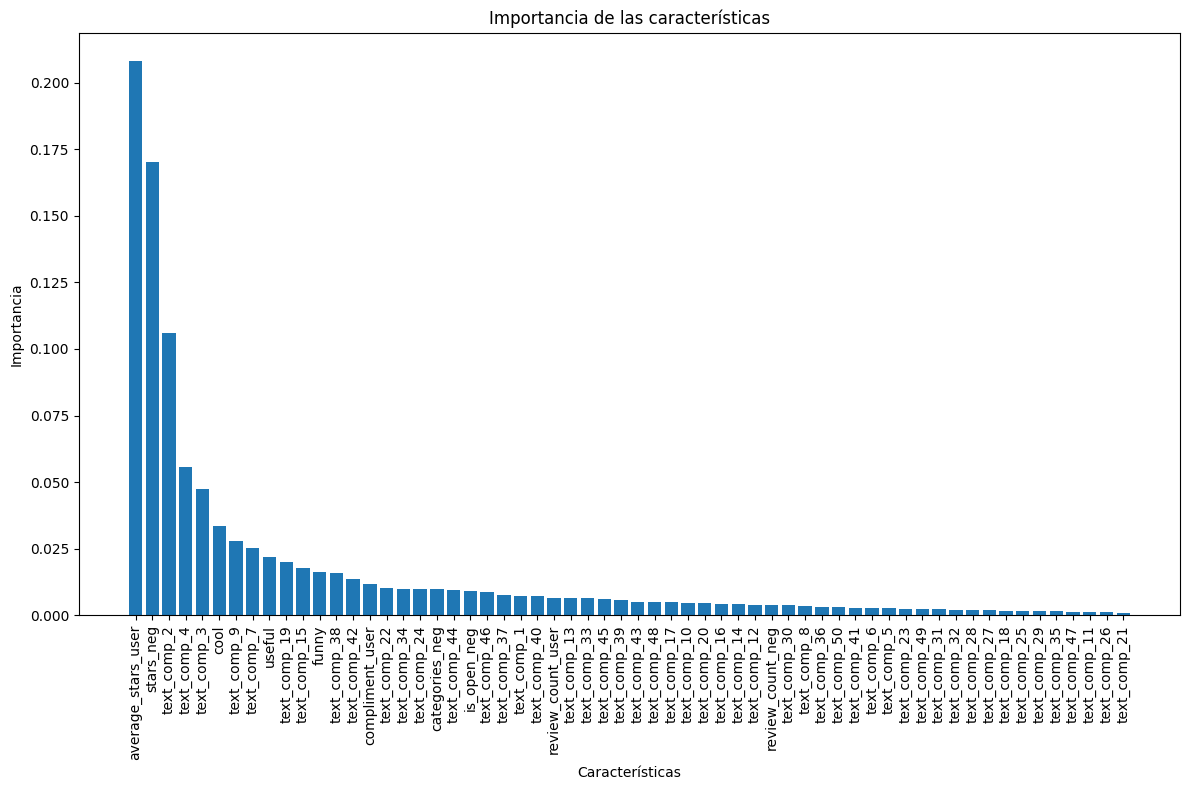

In [12]:
importances = reg.feature_importances_

numeric_feature_names = list(X_numeric.columns)
text_feature_names = [f"text_comp_{i+1}" for i in range(X_text_reduced.shape[1])]
feature_names = numeric_feature_names + text_feature_names

indices = np.argsort(importances)[::-1]

# Crear la gráfica
plt.figure(figsize=(12, 8))
plt.title("Importancia de las características")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=90)
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.tight_layout()
plt.show()

In [14]:
# Ahora, procesar el conjunto de test (sin ajustar de nuevo el vectorizador ni el SVD)
df_test = pd.read_csv('../data/test_reviews_merged_final.csv')
df_test['text'] = df_test['text'].fillna("")

Y_numeric = df_test[["useful", "funny", "cool", "stars_neg", "review_count_neg", "categories_neg", "review_count_user", "average_stars_user", "compliment_user"]].copy()
Y_numeric["is_open_neg"] = df_test["is_open_neg"].astype(int)

Y_numeric

,useful,funny,cool,stars_neg,review_count_neg,categories_neg,review_count_user,average_stars_user,compliment_user,is_open_neg
0,-0.063127,-0.164229,0.253789,4.5,1.375296,Restaurante,-0.001300,4.11,-0.032664,1
1,0.917552,-0.164229,0.759641,4.0,0.583200,Restaurante,0.679424,3.77,0.152543,1
2,0.263766,-0.164229,-0.252063,3.5,0.765382,Otros,-0.107919,2.92,-0.031454,1
3,0.263766,-0.164229,-0.252063,4.0,1.256481,Restaurante,0.269349,3.82,0.026650,1
4,-0.390020,-0.164229,-0.252063,2.5,3.561480,Hotelería,-0.271949,1.25,-0.033875,1
...,...,...,...,...,...,...,...,...,...,...
414760,-0.390020,-0.164229,-0.252063,4.0,15.997386,Restaurante,2.057274,3.53,0.042387,1
414761,-0.390020,-0.164229,-0.252063,4.0,-0.288106,Restaurante,-0.271949,5.00,-0.035085,1
414762,-0.390020,-0.164229,-0.252063,3.5,2.777305,Restaurante,2.409938,3.88,0.025440,0
414763,0.917552,-0.164229,0.253789,4.5,1.304007,Restaurante,2.951236,4.06,0.019387,0


In [15]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
Y_numeric['categories_neg'] = label_encoder.fit_transform(Y_numeric['categories_neg'])

Y_numeric.sample(5)

,useful,funny,cool,stars_neg,review_count_neg,categories_neg,review_count_user,average_stars_user,compliment_user,is_open_neg
276248,-0.390020,-0.164229,-0.252063,3.0,-0.296027,4,0.827051,3.26,-0.029033,1
28845,-0.063127,0.811751,-0.252063,3.5,3.094144,4,-0.124322,2.17,-0.032664,0
291,-0.063127,-0.164229,-0.252063,2.0,0.781224,4,-0.296553,1.00,-0.035085,1
56749,-0.063127,-0.164229,-0.252063,3.0,0.060417,4,-0.034106,3.21,-0.019349,1
3330,-0.063127,-0.164229,-0.252063,4.5,1.842632,4,4.312683,4.44,0.245752,1


In [16]:
Y_text_test_tfidf = tfidf.transform(df_test['text'])
Y_text_test_svd = svd.transform(Y_text_test_tfidf)

X_test = np.hstack([Y_numeric, Y_text_test_svd])

predictions = reg.predict(X_test)

In [17]:
# Crear el DataFrame con el formato requerido: review_id, stars
df_output = pd.DataFrame({
    'review_id': df_test['review_id'],
    'stars': predictions.round(0)
})

# Exportar el CSV con las predicciones
df_output.to_csv('xgboost_review_predictions_all_0.csv', index=False)
print("Predicciones exportadas a 'xgboost_review_predictions_neg_0.csv'")

Predicciones exportadas a 'xgboost_review_predictions_neg_0.csv'


# RandomForest (train + neg + DL)

In [3]:
df_train = pd.read_csv("../data/train_reviews_merged_neg.csv")
df_train['text'] = df_train['text'].fillna("")

df_train.sample(5)

,stars,useful,funny,cool,text,date,stars_neg,review_count_neg,is_open_neg,categories_neg,state_AZ_neg,state_FL_neg,state_IN_neg,state_LA_neg,state_MO_neg,state_NJ_neg,state_Others_neg,state_PA_neg,state_TN_neg
824997,5.0,-0.391093,-0.150312,-0.251644,GREAT DONUTS! Their regular glazed is off the ...,2017,4.0,1.406980,True,Restaurante,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
273042,3.0,-0.062341,-0.150312,-0.251644,How could I have forgotten to write this revie...,2019,4.0,5.803112,True,Otros,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
870046,5.0,-0.391093,-0.150312,-0.251644,OUTSTANDING!!!!!! Best omelette I've ever eate...,2017,4.5,1.438663,True,Restaurante,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
901079,5.0,-0.391093,-0.150312,-0.251644,I love Faiza! I have been coming to her for a...,2018,4.5,0.100021,True,Belleza,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
420332,5.0,-0.062341,-0.150312,0.762869,Love this place! Probably our favorite restaur...,2018,4.5,0.907959,True,Restaurante,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Omito state_* ya que no son muy representativas para el modelo

In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X_numeric = df_train[["useful", "funny", "cool", "stars_neg", "review_count_neg", "categories_neg"]].copy()
X_numeric["is_open_neg"] = df_train["is_open_neg"].astype(int)

X_numeric

,useful,funny,cool,stars_neg,review_count_neg,categories_neg,is_open_neg
0,-0.391093,-0.150312,-0.251644,4.5,0.773303,Restaurante,1
1,0.266410,-0.150312,0.255613,2.5,-0.177212,Otros,1
2,-0.391093,-0.150312,-0.251644,2.5,-0.296027,Compras,1
3,-0.391093,-0.150312,-0.251644,4.5,0.226757,Restaurante,0
4,2.896420,1.654029,3.299152,4.0,-0.105924,Restaurante,1
...,...,...,...,...,...,...,...
967779,-0.062341,-0.150312,-0.251644,4.5,0.812908,Restaurante,0
967780,-0.391093,-0.150312,-0.251644,4.5,0.900038,Restaurante,1
967781,-0.391093,-0.150312,0.255613,4.5,1.961447,Restaurante,1
967782,-0.391093,-0.150312,-0.251644,4.5,21.478689,Restaurante,1


In [5]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
X_numeric['categories_neg'] = label_encoder.fit_transform(X_numeric['categories_neg'])

X_numeric.sample(5)

,useful,funny,cool,stars_neg,review_count_neg,categories_neg,is_open_neg
157483,1.910166,-0.150312,-0.251644,4.0,-0.169291,0,1
967352,0.595161,-0.150312,-0.251644,4.0,0.298045,4,1
146832,-0.062341,-0.150312,-0.251644,4.5,0.100021,0,1
226732,-0.391093,0.300774,-0.251644,3.0,1.684213,4,1
631245,-0.391093,-0.150312,-0.251644,4.0,4.203078,3,1


In [ ]:
# from sentence_transformers import SentenceTransformer
# import numpy as np

# model = SentenceTransformer('all-MiniLM-L12-v2')

# corpus = list(df_train["text"])

# embeddings = model.encode(corpus, show_progress_bar=True)

# np.save('embeddings_train_DL.npy', embeddings)

In [8]:
embeddings = np.load('../weight/embeddings_train_DL.npy')

In [9]:
svd = TruncatedSVD(n_components=50, random_state=42)
X_text_reduced = svd.fit_transform(embeddings)

In [10]:
embeddings.shape, X_numeric.shape, X_text_reduced.shape

((967784, 384), (967784, 7), (967784, 50))

In [11]:
X_final = np.hstack([X_numeric.values, X_text_reduced])

y = df_train["stars"]

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=75, random_state=42, verbose=1, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 13.2min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.4s


MAE: 0.6751276328838287


[Parallel(n_jobs=16)]: Done  75 out of  75 | elapsed:    1.1s finished


In [ ]:
model.save('random_forest_model_DL.pkl')

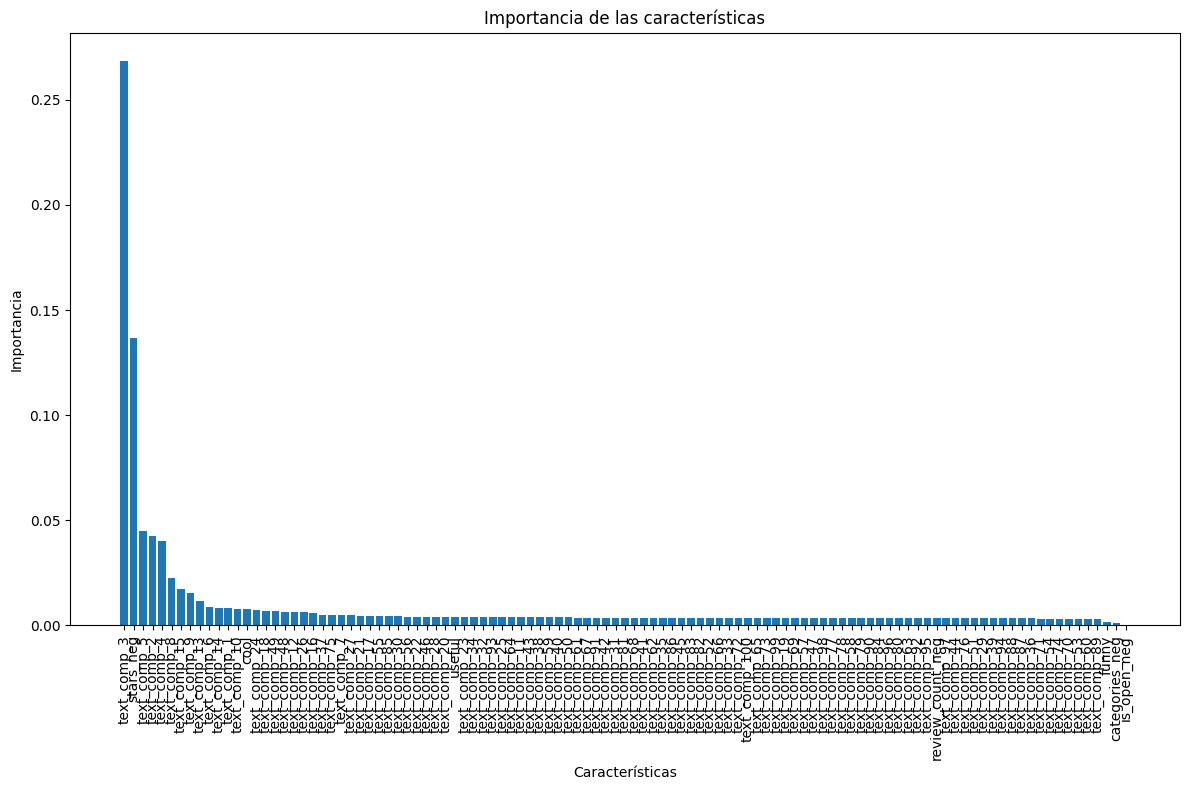

In [26]:
importances = model.feature_importances_

numeric_feature_names = list(X_numeric.columns)
text_feature_names = [f"text_comp_{i+1}" for i in range(X_text_reduced.shape[1])]
feature_names = numeric_feature_names + text_feature_names

indices = np.argsort(importances)[::-1]

# Crear la gráfica
plt.figure(figsize=(12, 8))
plt.title("Importancia de las características")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=90)
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.tight_layout()
plt.show()

In [9]:
# Ahora, procesar el conjunto de test (sin ajustar de nuevo el vectorizador ni el SVD)
df_test = pd.read_csv('../data/test_reviews_merged_neg.csv')
df_test['text'] = df_test['text'].fillna("")

Y_numeric = df_test[["useful", "funny", "cool", "stars_neg", "review_count_neg", "categories_neg"]].copy()
Y_numeric["is_open_neg"] = df_test["is_open_neg"].astype(int)

Y_numeric

,useful,funny,cool,stars_neg,review_count_neg,categories_neg,is_open_neg
0,-0.063127,-0.164229,0.253789,4.5,1.375296,Restaurante,1
1,0.917552,-0.164229,0.759641,4.0,0.583200,Restaurante,1
2,0.263766,-0.164229,-0.252063,3.5,0.765382,Otros,1
3,0.263766,-0.164229,-0.252063,4.0,1.256481,Restaurante,1
4,-0.390020,-0.164229,-0.252063,2.5,3.561480,Hotelería,1
...,...,...,...,...,...,...,...
414760,-0.390020,-0.164229,-0.252063,4.0,15.997386,Restaurante,1
414761,-0.390020,-0.164229,-0.252063,4.0,-0.288106,Restaurante,1
414762,-0.390020,-0.164229,-0.252063,3.5,2.777305,Restaurante,0
414763,0.917552,-0.164229,0.253789,4.5,1.304007,Restaurante,0


In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
Y_numeric['categories_neg'] = label_encoder.fit_transform(Y_numeric['categories_neg'])

Y_numeric.sample(5)

,useful,funny,cool,stars_neg,review_count_neg,categories_neg,is_open_neg
244415,-0.063127,-0.164229,0.253789,4.0,5.937768,4,1
346947,-0.063127,-0.164229,0.253789,3.5,-0.042556,4,0
242858,-0.390020,-0.164229,-0.252063,4.5,13.755754,4,0
314009,-0.063127,-0.164229,-0.252063,4.0,7.957612,4,1
119624,-0.063127,-0.164229,-0.252063,4.0,4.662494,0,1


In [14]:
corpus_test = list(df_test['text'])
embeddings_test = model.encode(corpus_test, show_progress_bar=True)

np.save('embeddings_test_DL.npy', embeddings_test)

KeyboardInterrupt: 

In [ ]:
X_test = np.hstack([Y_numeric, Y_text_test_svd])

predictions = model.predict(X_test)

In [ ]:
# Crear el DataFrame con el formato requerido: review_id, stars
df_output = pd.DataFrame({
    'review_id': df_test['review_id'],
    'stars': predictions.round(0)
})

# Exportar el CSV con las predicciones
df_output.to_csv('random_forest_review_predictions_neg_1.csv', index=False)
print("Predicciones exportadas a 'random_forest_review_predictions_neg_1.csv'")

Predicciones exportadas a 'random_forest_review_predictions_neg_1.csv'
